### Imports

In [1]:
import sys
import os
import h5py
import torch
import matplotlib.pyplot as plt
import numpy as np
import glob
import random
from typing import Union, Tuple, Optional
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from src.models.dqfno import DQFNO
from src.losses.data_losses import LpLoss, H1Loss
from src.losses.physical_loss import PoissonResidual
from src.training.adamw import AdamW
from src.losses.custom_losses import MultiTaskLoss

### Data Utils

In [2]:
data_path = "/Users/anthonypoole/Data/TACC/hw2d_sim_step0.025_end1_pts512_c11_k015_N3_nu5e-8_20250205112740_25678_3.h5"
with h5py.File(data_path, 'r') as f:
    print(f['density'].shape)
    print(f.keys())

(8001, 64, 64)
<KeysViewHDF5 ['density', 'energy', 'enstrophy', 'enstrophy_phi', 'gamma_c', 'gamma_n', 'gamma_n_spectral', 'kinetic_energy', 'omega', 'phi', 'state_density', 'state_omega', 'state_phi', 'thermal_energy', 'time']>


In [3]:
def load_h5_pair(input_file: str, target_file: str, device: torch.device,
                 derived: bool = False) -> Union[Tuple[torch.Tensor, torch.Tensor],
                                                 Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]:
    """
    Loads input and target data from HDF5 files.

    :param input_file: Path to the input file.
    :param target_file: Path to the target file.
    :param device: Torch device.
    :param derived: Whether to load the derived gamma_n quantity.
    :return: Tuple of (x, y) if not derived; otherwise (x, y, gamma_n).
    """
    def load_data(file: str) -> torch.Tensor:
        with h5py.File(file, 'r') as f:
            density = f['density'][:]
            omega = f['omega'][:]
            phi = f['phi'][:]
            gamma_n = f['gamma_n'][:]
            # Stack along channel dimension and add a batch dimension.
            data = torch.tensor(np.stack((density, omega, phi), axis=1), dtype=torch.float32)
            # Rearranging dimensions as needed: (B, var_dim, T, H, W)
            return (data.unsqueeze(0).permute(0, 2, 1, 3, 4), torch.from_numpy(gamma_n))

    x = load_data(input_file)
    y = load_data(target_file)
    gamma_n: Optional[torch.Tensor] = None

    if derived:
        with h5py.File(target_file, 'r') as f:
            gamma_n = torch.tensor(f['gamma_n'][:], dtype=torch.float32)

    if derived:
        assert gamma_n is not None  # For type-checkers.
        return x.to(device), y.to(device), gamma_n.to(device)
    else:
        return (x[0].to(device), x[1].to(device)) , (y[0].to(device), y[1].to(device))
# Gather HDF5 file pairs.
input_pattern = "../data/input*.h5"
target_pattern = "../data/target*.h5"
input_files = sorted(glob.glob(input_pattern))
target_files = sorted(glob.glob(target_pattern))
paired_files = list(zip(input_files, target_files))
random.shuffle(paired_files)
split_idx = int(.8 * len(paired_files))
train_files = paired_files[:split_idx]
test_files = paired_files[split_idx:]
for (input_file, target_file) in train_files:
    data = load_h5_pair(input_file, target_file, 'cpu')

### Test Loss Functions

In [4]:
lpLoss= LpLoss(d=4,p=2, reduction='mean')
h1Loss = H1Loss(d=2)
pLoss = PoissonResidual
mse = torch.nn.functional.mse_loss
# optim = AdamW(model.parameters(), lr = .00001)

In [5]:
def train(model, criterion, p = False):
    
    losses = []
    if p:
        print("oooo")
        criterion = PoissonResidual(model.derived_module.hw, scale=10000)
    model.train()
    optim = torch.optim.Adam(model.parameters(), lr=.0001)
    for j in range(1):
        for i, (input_file, target_file) in enumerate(train_files):
            optim.zero_grad()
            data = load_h5_pair(input_file, target_file, 'cpu')
            x, y = data
            
            # Reshape x and y to: Batch, Channels, Time, V, X, Y
            x_gamma_n = x[1]
            x = (x[0].reshape(1, 1, 10, 3, 64, 64), x[1])
            y_gamma_n = y[1]
            y = (y[0].reshape(1, 1, 10, 3, 64, 64), y[1])
            
            # Forward pass through the model.
            x = model(x)
            # x = model(x)
            
            # Compute the loss (MSE loss in this example)
            # loss = torch.nn.functional.mse_loss(x, y) if j <= 0 else torch.nn.functional.mse_loss(derived.squeeze(0), y_gamma_n)
            loss = criterion(x,y)
            loss.backward()
            optim.step()
            
            if i % 10 == 0:
                print(f"Loss: {float(loss)}")
                losses.append(float(loss))


# lp_model = train(criterion=LpLoss(d=4,p=2, reduction='mean'))
# h1_model = train(h1Loss)
# p_model = train(PoissonResidual, True)
# mse_model = train(mse)

# Create model
modes = [(16,16), (32,32), (8,8)]
mulit_model = DQFNO(
    modes=modes,
    in_channels=1,
    out_channels=1,
    hidden_channels=32,
)
mulit_model.cpu()


# To create a custom loss function create lambdas to wrap losses 
LpLoss = LpLoss(d=4, p=2 , reduction='mean')
H1Loss = H1Loss(d=2)
PLoss = PoissonResidual(mulit_model.derived_module.hw)
MseLoss = torch.nn.MSELoss()
lp_loss_state = lambda pred, target: LpLoss(pred, target)
h1_loss = lambda pred, target: H1Loss(pred, target) 
p_loss = lambda pred, target: PLoss(pred, target)
mse_derived_loss = lambda pred, target: MseLoss(pred, target)
# Input selectors for multi_output:
selector_state = lambda y_pred, y: (y_pred[0], y[0])
selector_derived = lambda y_pred, y: (y_pred[1], y[1])

loss_obj = MultiTaskLoss(
    loss_functions=[lp_loss_state, h1_loss, p_loss, mse_derived_loss],
    scales=[0.40, 0.30, 0.15, 0.15],
    multi_output=True,
    input_selectors=[selector_state, selector_state, selector_state, selector_derived]
)
train(mulit_model, loss_obj) 

Loss: 9.458207130432129
Loss: 9.44302749633789
Loss: 9.431882858276367
Loss: 9.441740036010742
Loss: 9.426966667175293
Loss: 9.423934936523438
Loss: 9.410324096679688
Loss: 9.407470703125
Loss: 9.373589515686035
Loss: 9.328261375427246
Loss: 9.275330543518066
Loss: 9.189732551574707
Loss: 9.072455406188965
Loss: 8.859904289245605
Loss: 8.573740005493164
Loss: 8.151422500610352
Loss: 7.576494216918945
Loss: 6.911526203155518
Loss: 6.416348934173584
Loss: 6.147613525390625
Loss: 5.909374713897705
Loss: 5.692319393157959
Loss: 5.544108867645264
Loss: 5.4635844230651855
Loss: 5.324909210205078
Loss: 5.119935512542725
Loss: 5.065641403198242
Loss: 4.9695000648498535
Loss: 4.9600419998168945
Loss: 4.769210338592529
Loss: 4.6638383865356445
Loss: 4.631948947906494
Loss: 4.603669166564941
Loss: 4.533529758453369
Loss: 4.546612739562988
Loss: 4.430428981781006
Loss: 4.3586883544921875
Loss: 4.583921432495117
Loss: 4.335605144500732
Loss: 4.3230390548706055
Loss: 4.228641986846924
Loss: 4.192534

In [11]:
# Test the trained model
def show_model(model):
    with torch.no_grad():
        plots = 10
        fig, ax = plt.subplots(plots,3, figsize=(16,30))

        gamma_rel_errors = []
        for i, (input_file, target_file) in enumerate(test_files):
            if i >=plots:
                break
            data = load_h5_pair(input_file, target_file, 'cpu')
            x, y = data
            x_gamma_n = x[1]
            y_gamma_n = y[1]
            x = (x[0].reshape(1, 1, 10, 3, 64,64), x[1]) # B, C, T, V, X, Y
            y = (y[0].reshape(1, 1, 10, 3, 64,64), y[1]) # B, C, T, V, X, Y
            pred, pred_gamma_n = model(x)
            # print(pred_gamma_n.shape)
            # print(abs(pred_gamma_n-y_gamma_n)/y_gamma_n)
            gamma_rel_errors.append((abs(pred_gamma_n-y_gamma_n)/y_gamma_n).mean())
            
            x_image = x[0][0,0,0,1]
            y_image = y[0][0,0,0,1]
            pred_image = pred[0,0,0,1]
            ax[i,0].imshow(x_image)
            ax[i,0].set_title(f"Input for {i}")
            ax[i,0].axis('off')
            ax[i,1].imshow(y_image)
            ax[i,1].set_title(f"Ground truth for {i}")
            ax[i,1].axis('off')
            ax[i,2].imshow(pred_image)
            ax[i,2].set_title(f"Prediction for {i}")
            ax[i,2].axis('off')

        print(gamma_rel_errors)
        plt.tight_layout()
        plt.show()

[tensor(0.0549), tensor(0.1284), tensor(0.0821), tensor(0.1020), tensor(0.0569), tensor(0.1517), tensor(0.1073), tensor(0.1463), tensor(0.0366), tensor(0.0985)]


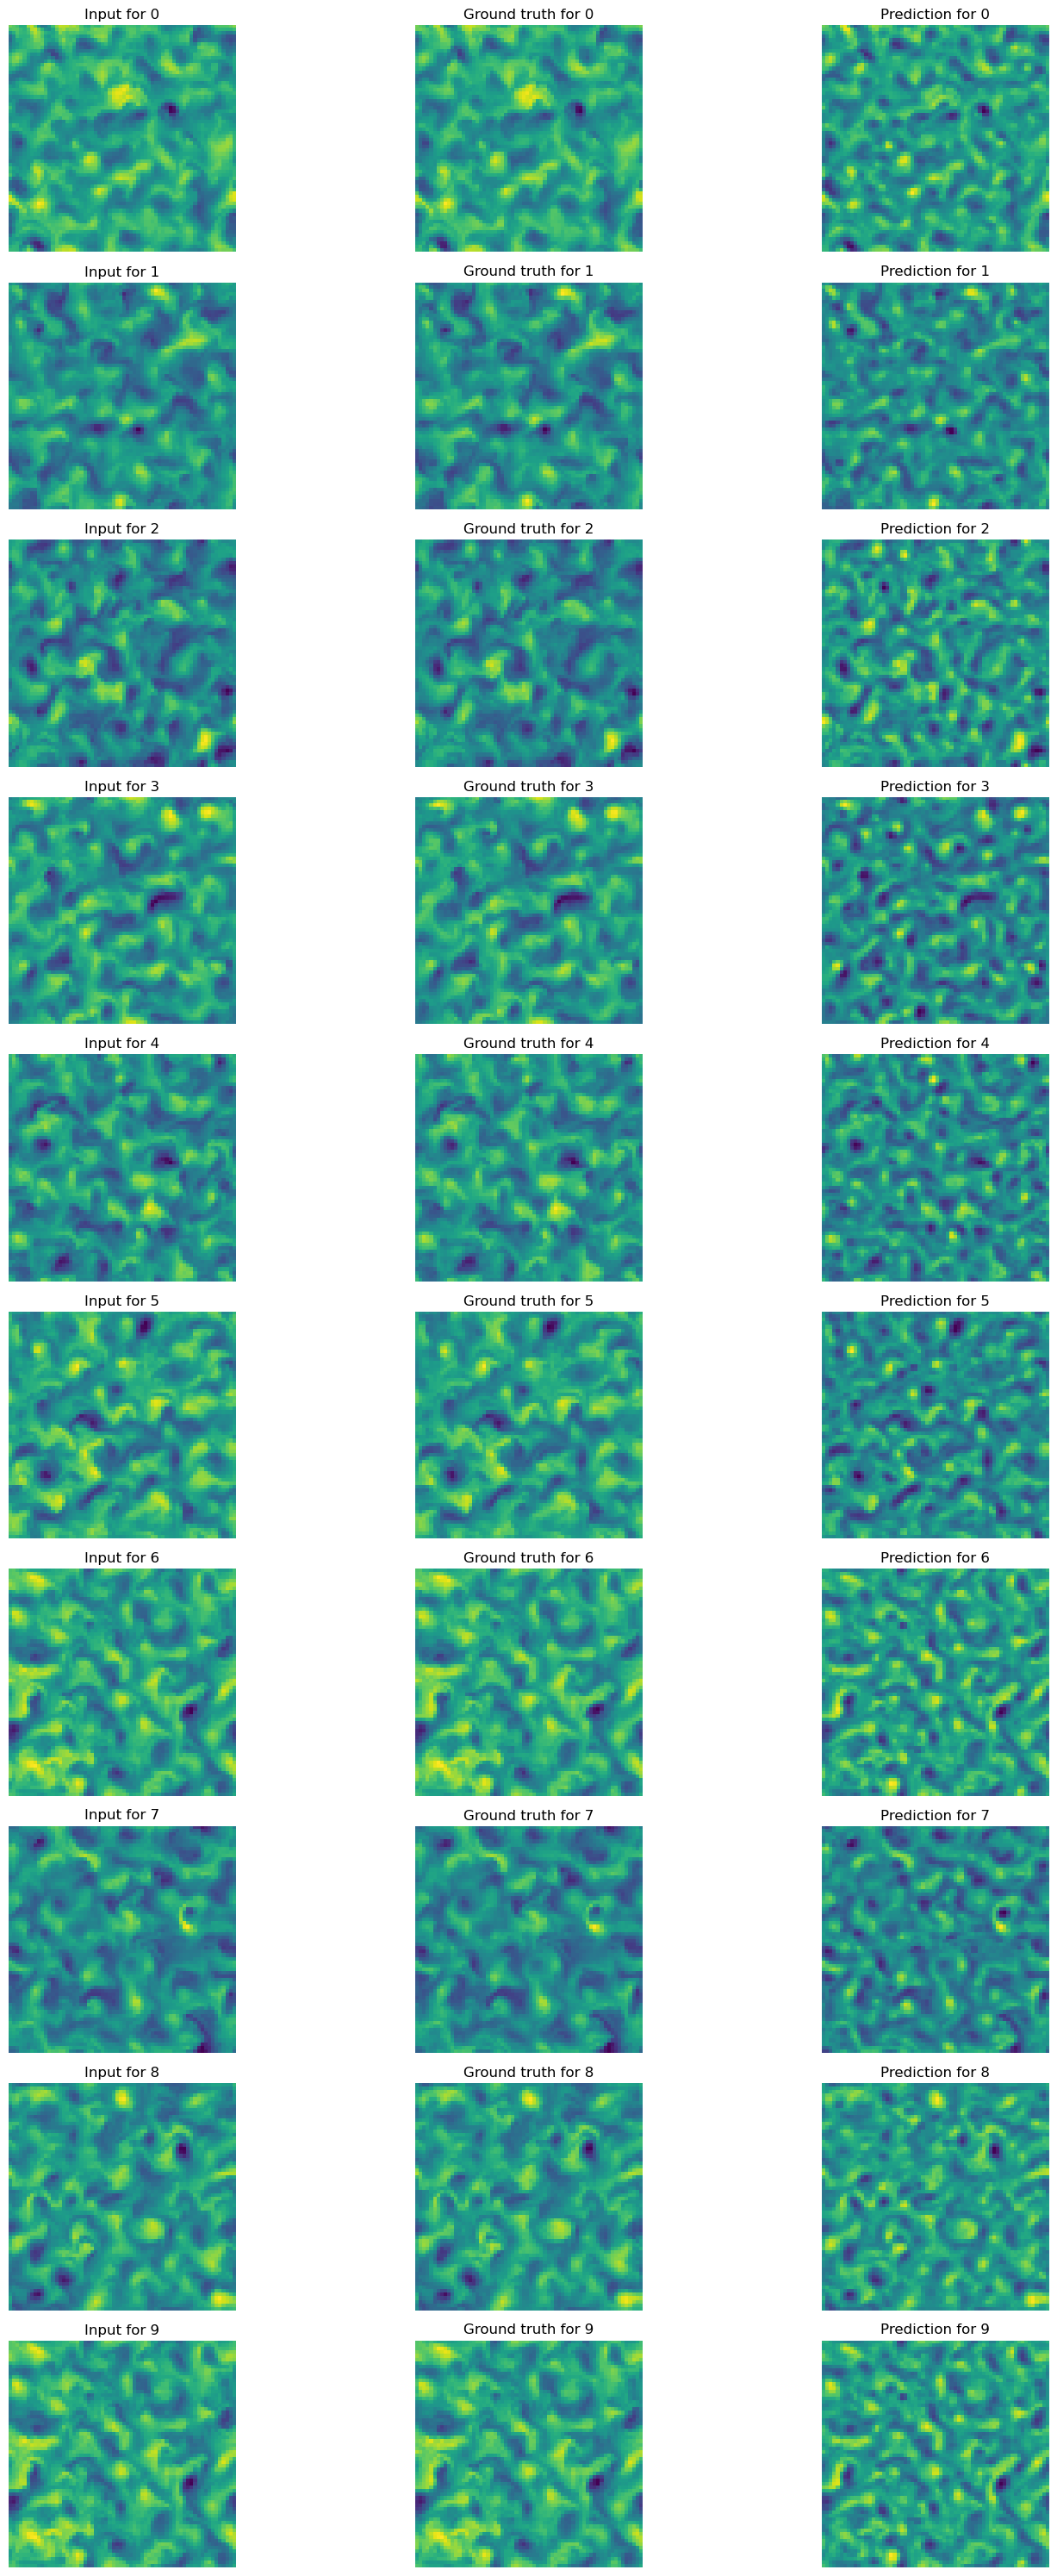

In [12]:
show_model(mulit_model)

In [8]:
show_model(lp_model)

NameError: name 'lp_model' is not defined

[tensor(1.0018), tensor(1.0020), tensor(0.9996), tensor(1.0009), tensor(1.0014), tensor(1.0019), tensor(1.0007), tensor(1.0012), tensor(1.0012), tensor(1.0006)]


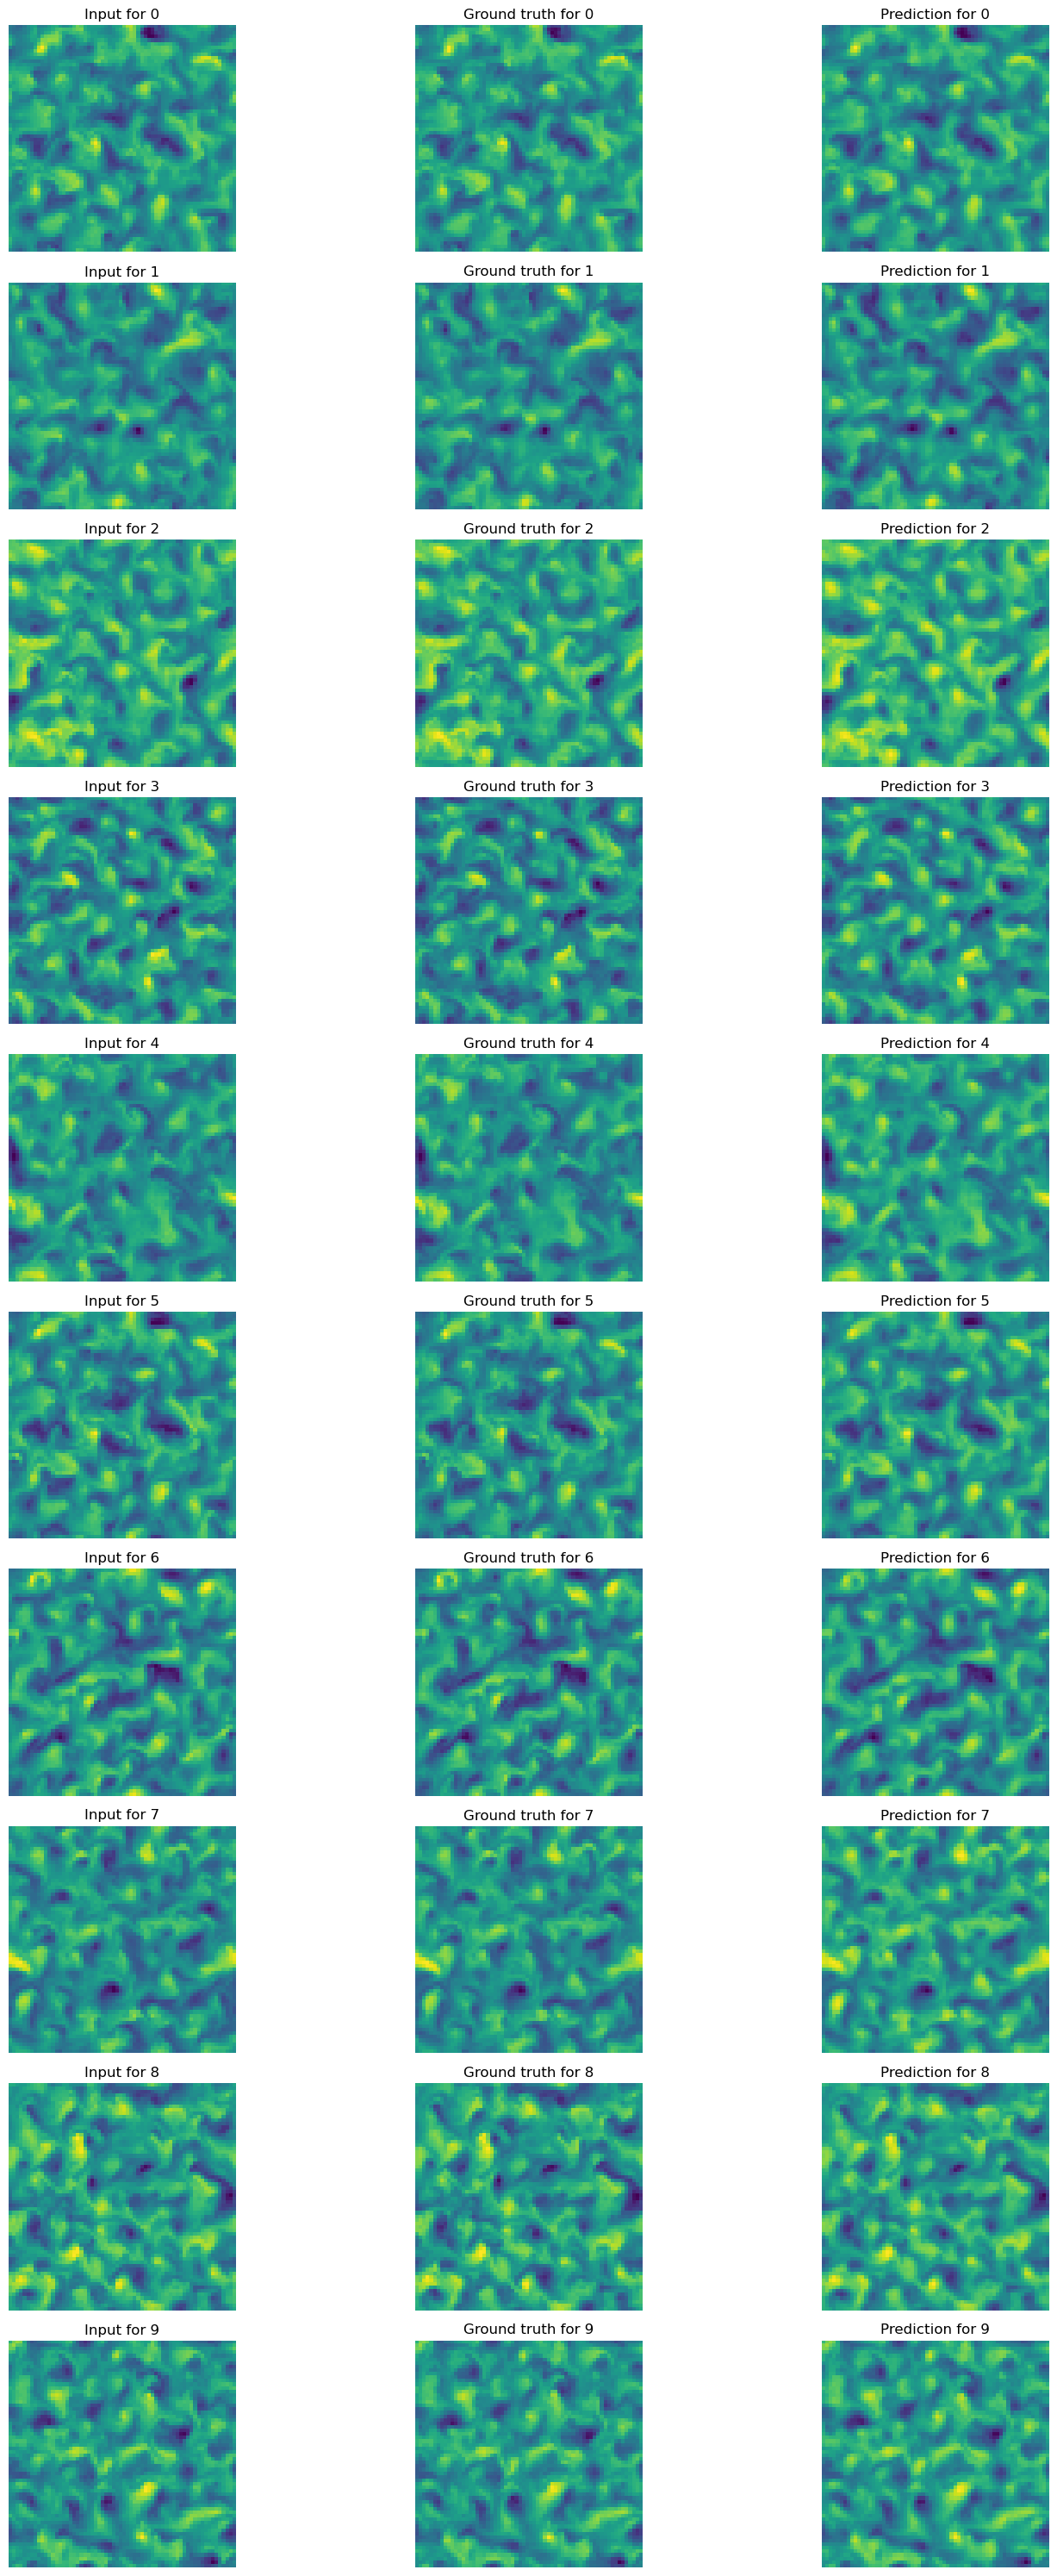

In [ ]:
show_model(h1_model)

[tensor(0.9990), tensor(0.9996), tensor(0.9994), tensor(0.9993), tensor(0.9991), tensor(0.9992), tensor(0.9990), tensor(0.9993), tensor(0.9990), tensor(0.9991)]


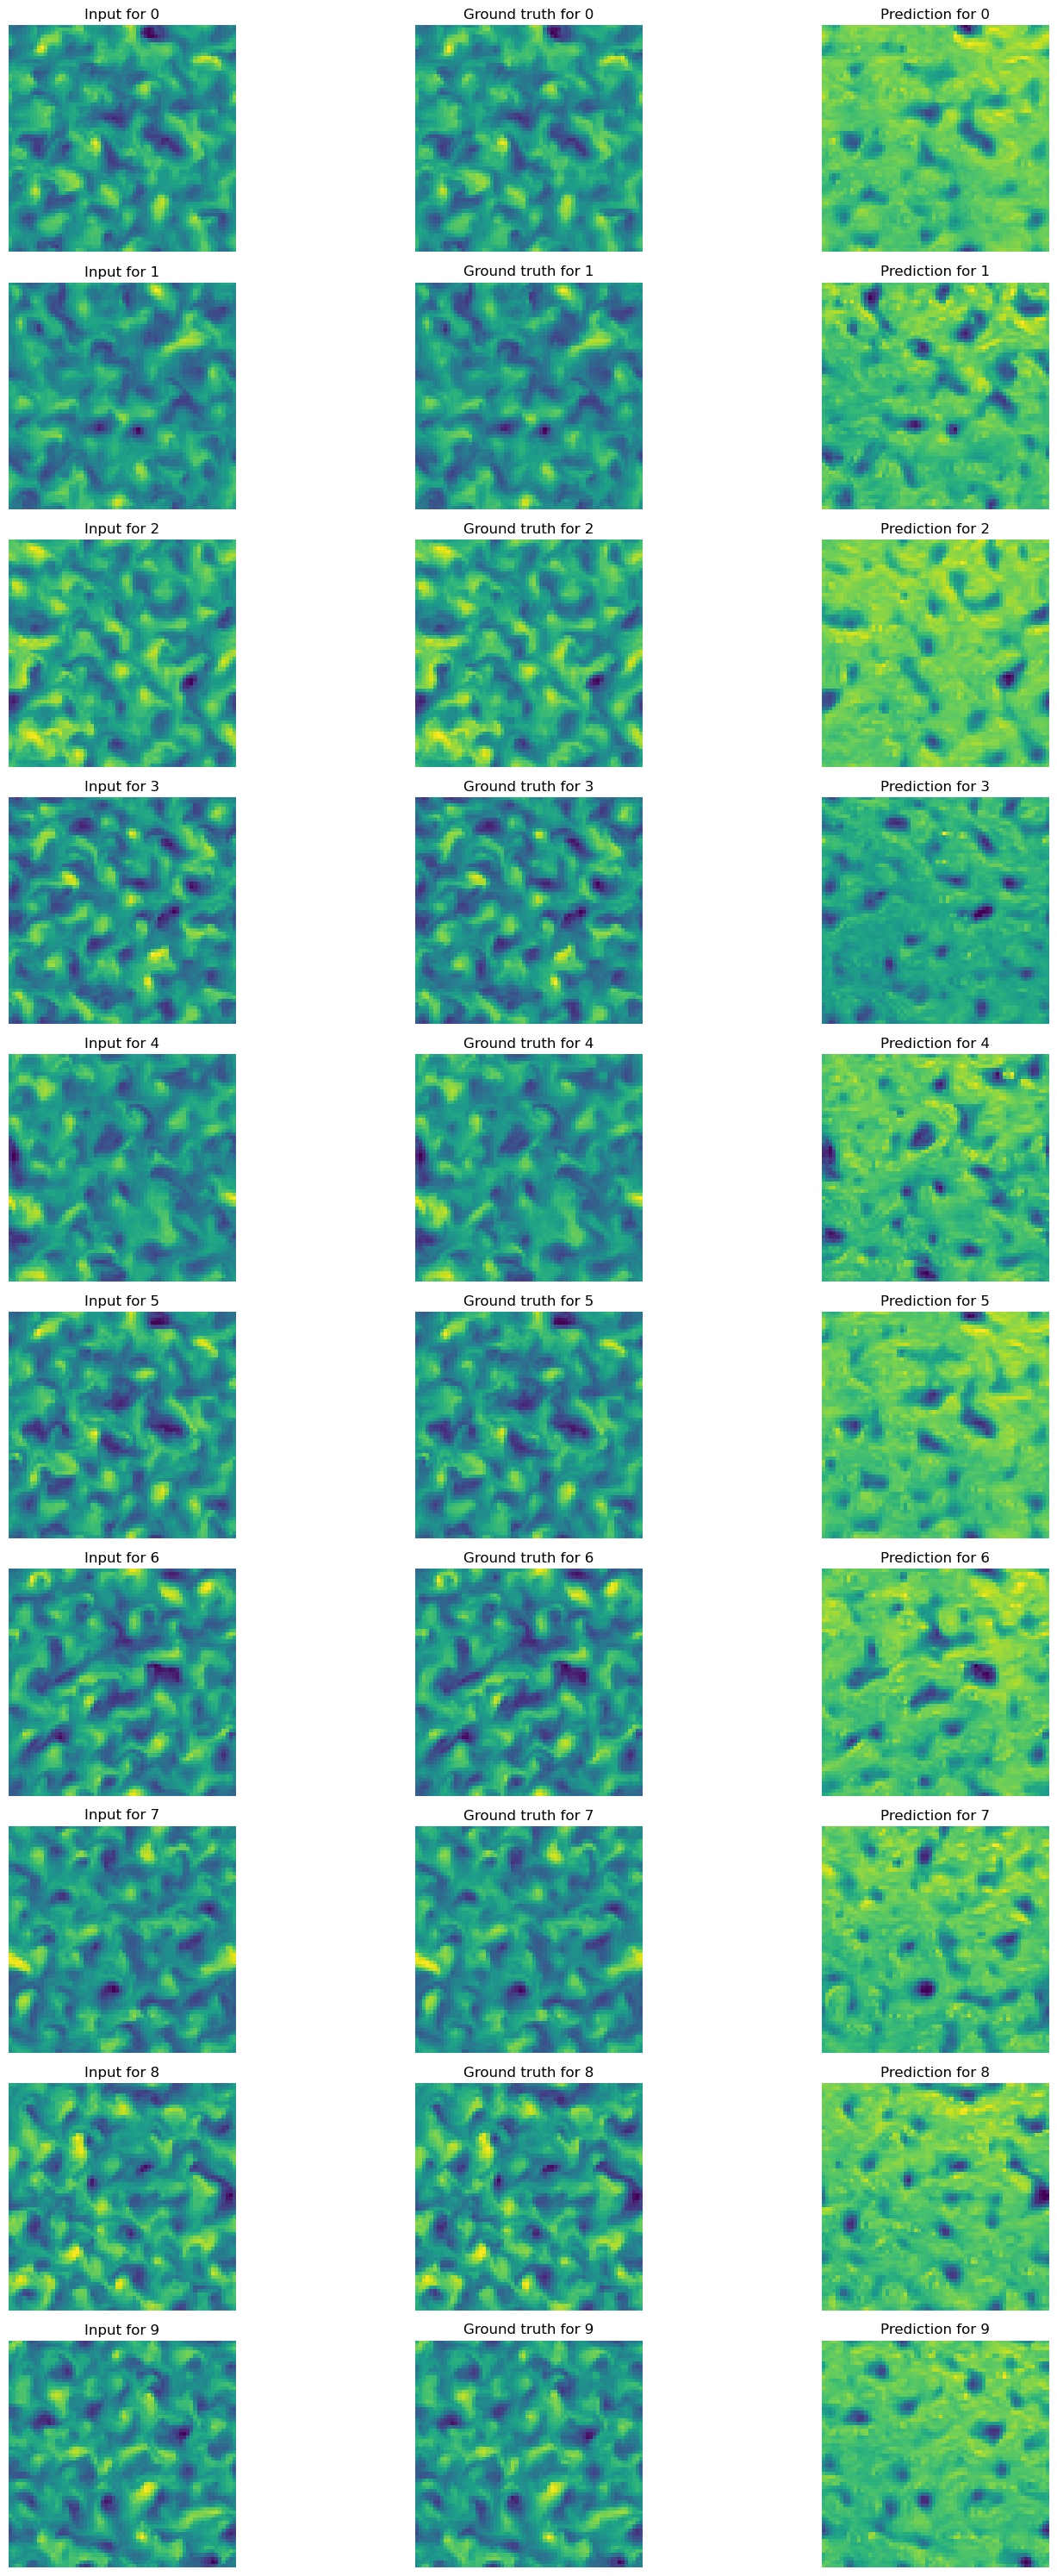

In [ ]:
show_model(p_model)

[tensor(1.0309), tensor(1.0270), tensor(1.0234), tensor(1.0303), tensor(1.0267), tensor(1.0291), tensor(1.0309), tensor(1.0225), tensor(1.0208), tensor(1.0299)]


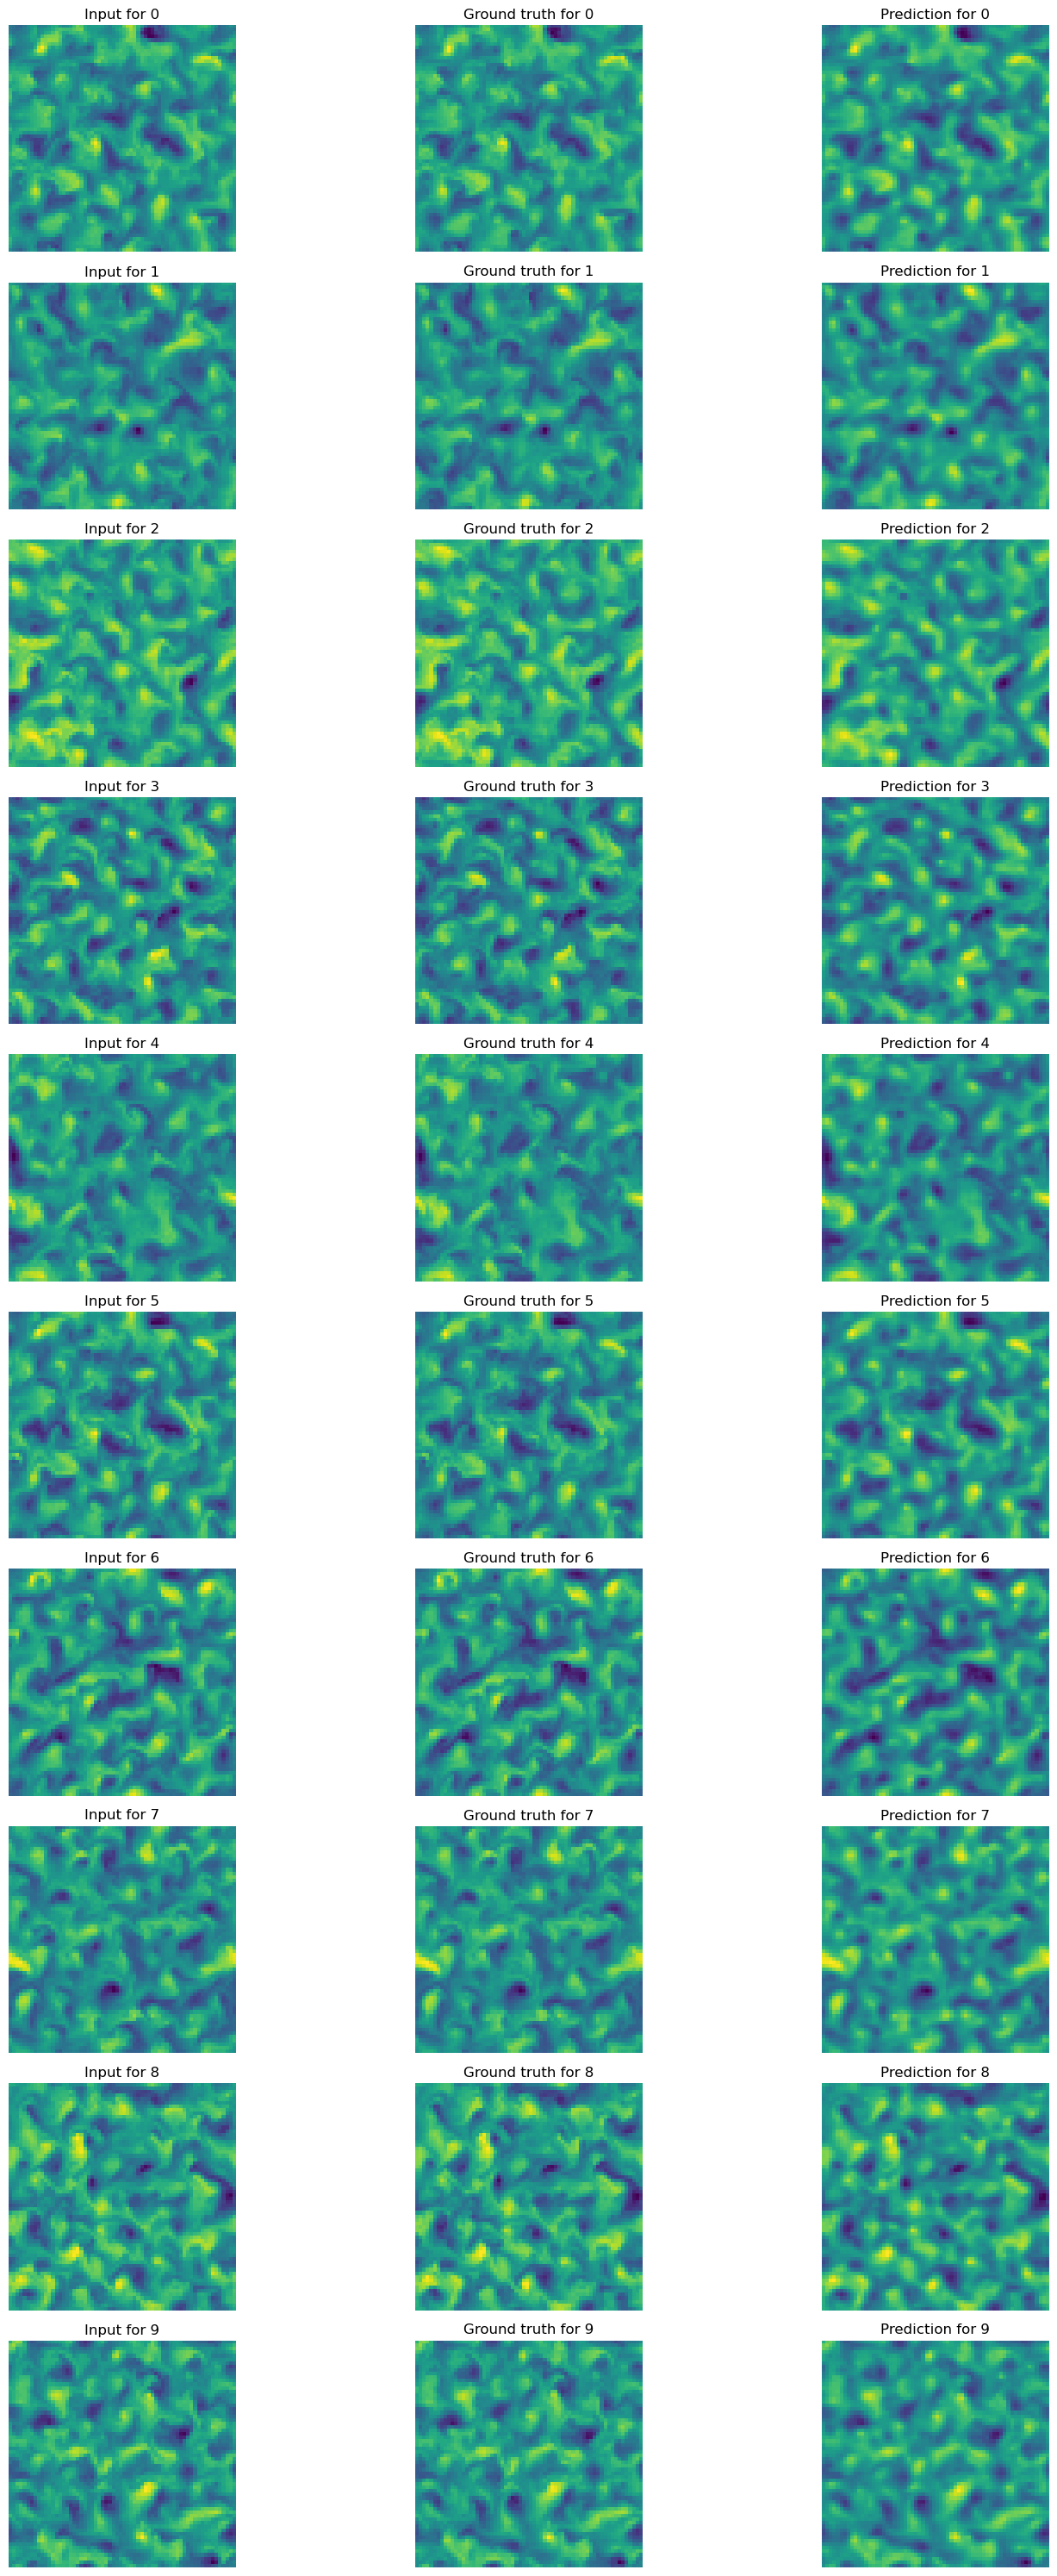

In [ ]:
show_model(mse_model)